# M1 Applied Data Science - Coursework Submission
### Steven Dillmann

**MPhil Data Intensive Science | University of Cambridge**

20th December 2023

[sd2022@cam.ac.uk](sd2022@cam.ac.uk)

This notebook was written by Steven Dillmann as part of the coursework submission for the M1 Applied Data Science module in the MPhil in Data Intensive Science at the University of Cambridge. The coursework assignment can be found here: [M1 Applied Data Science - Coursework Assignment](../DIS_MPhil_M1_Coursework.pdf).

In [14]:
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install tabulate   

In [15]:
# Import required libraries
import pandas as pd
import seaborn as sns
import warnings
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tabulate import tabulate
warnings.simplefilter(action='ignore', category=FutureWarning)

# Set up matplotlib style and colours
import matplotlib.pyplot as plt
plt.style.use('sd2022.mplstyle')
from matplotlib.colors import ListedColormap, LogNorm, Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.family'] = 'DejaVu Sans'
sd2022_blue = '#3772ff'
sd2022_red = '#FF033E'
sd2022_green = '#05a45c'
sd2022_purple = '#994d9e' # DIS logo colour
sd2022_orange = '#ff8243'
sd2022_pink = '#df37d6'
sd2022_turq = '#30d5c8'
sd2022_gold = '#cfbd62' 
sd2022_silver = '#C0C0C0'
color_dict = {'red':   [(0.0, 1.0, 1.0), (1.0, 1.0, 1.0)],
              'green': [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)],
              'blue':  [(0.0, 0.0, 0.0), (1.0, 0.0, 0.0)]}
cmap_blue = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_blue,'black'], N=256)
cmap_red = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_red,'black'], N=256)
cmap_green = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_green,'black'], N=256)
cmap_orange = mcolors.LinearSegmentedColormap.from_list('my_colormap', ['white',sd2022_orange,'black'], N=256)
cmap_owp = mcolors.LinearSegmentedColormap.from_list('my_colormap', [sd2022_orange, '#F0F0F0', sd2022_purple], N=256)
cmap_twp = mcolors.LinearSegmentedColormap.from_list('my_colormap', [sd2022_turq, '#F0F0F0', sd2022_pink], N=256)

cmap_sd2022 = mcolors.LinearSegmentedColormap.from_list('my_colormap', [sd2022_blue,sd2022_red,sd2022_green], N=256)
colors_sd2022 = ListedColormap([sd2022_blue, sd2022_red, sd2022_green])
colors_sd2022_2 = ListedColormap([sd2022_green, sd2022_red, sd2022_blue])

# Set up some random seeds
seed_dob = 260699
seed_fave_song = 505
seed_football_number = 11
seed_year = 2023
seed_love = 711

## Question 5 - Baseline Dataset: Unsupervised Learning - Clustering

In [16]:
# Load dataset D into a dataframe
file_path = '../data/ADS_baselineDataset_preprocessed.csv'
df = pd.read_csv(file_path,index_col=0)

(a) Apply two different clustering techniques to the dataset (excluding the class labels). In your report, briefly explain the differences between the two methods and in more detail explain the difference in outputs between the two methods when applied to this dataset. Include a contingency table to summarise the number of observations assigned to each cluster using each technique. You may need to choose an appropriate number of clusters and justify this choice.


In [17]:
# === Data Preprocessing ===========================================================================

# Split into features X and labels y
X = df.drop('type', axis=1)
y = np.array(df['type'])

# Scale features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled['type'] = y

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=['PC_1','PC_2'])
df_pca['type'] = y

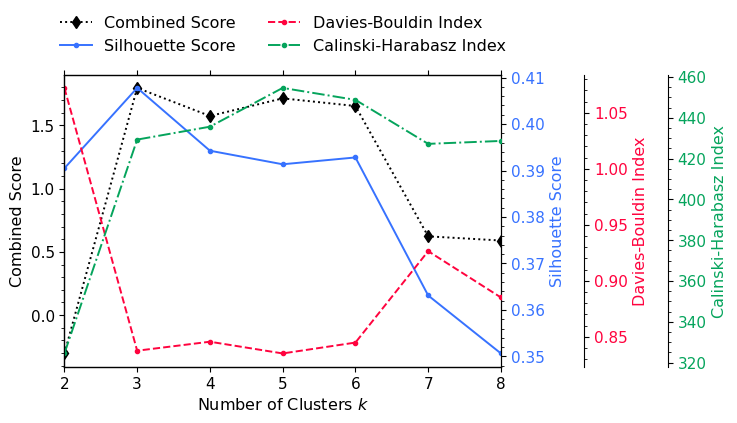

Optimal number of clusters based on Silhouette score: 3
Maximum Silhouette score: 0.408
Optimal number of clusters based on Davies-Bouldin index: 5
Minimum Davies-Bouldin index: 0.835
Optimal number of clusters based on Calinski-Harabasz index: 5
Maximum Calinski-Harabasz index: 454.645
Optimal number of clusters based on combined score: 3
Maximum combined score: 1.795


In [18]:
# === Find optimal number of clusters (k-means Clustering) =========================================

# Define combined score for different values of k
def calculate_combined_scores(silhouette_scores, ch_scores, db_scores):
    # Normalise scores
    def normalise_scores(scores):
        return [(s - min(scores)) / (max(scores) - min(scores)) for s in scores]
    silhouette_norm = normalise_scores(silhouette_scores)
    ch_norm = normalise_scores(ch_scores)
    db_norm = normalise_scores(db_scores)
    # Calculate combined score as `silhouette_norm + ch_norm - db_norm
    combined_scores = []
    for i in range(len(silhouette_scores)):
        combined_score = silhouette_norm[i] + ch_norm[i] - db_norm[i]
        combined_scores.append(combined_score)
    return combined_scores

# Calculate silhouette scores, Davies-Bouldin scores, and Calinski-Harabasz scores for different values of k
silhouette_scores = []
db_scores = []
ch_scores = []
k_list = list(range(2, 9))
for k in k_list:
    # Apply K-means clustering with k clusters
    kmeans = KMeans(n_clusters=k, random_state=seed_year)
    cluster_labels = kmeans.fit_predict(X_pca)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    # Calculate Davies-Bouldin score
    db_index = davies_bouldin_score(X_pca, cluster_labels)
    db_scores.append(db_index)
    # Calculate Calinski-Harabasz score
    ch_index = calinski_harabasz_score(X_pca, cluster_labels)
    ch_scores.append(ch_index)

# Calculate combined scores for different values of k
combined_scores = calculate_combined_scores(silhouette_scores, ch_scores, db_scores)

# Plot scores for different values of k
fig, ax1 = plt.subplots(figsize=(7.5, 4.5))

# Plot combined score
ax1.plot(k_list, combined_scores, marker='d', linestyle=':', color='black', label='Combined Score')
ax1.set_xlabel('Number of Clusters $k$')
ax1.set_ylabel('Combined Score', color='black')
ax1.tick_params('y', colors='black')

# Plot silhouette score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color=sd2022_blue)
ax2.plot(k_list, silhouette_scores, marker='.', linestyle='-', color=sd2022_blue, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=sd2022_blue)

# Plot Davies-Bouldin Index
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Davies-Bouldin Index', color=sd2022_red)
ax3.plot(k_list, db_scores, marker='.', linestyle='--', color=sd2022_red, label='Davies-Bouldin Index')
ax3.tick_params(axis='y', labelcolor=sd2022_red)

# Plot Calinski-Harabasz Index
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  
ax4.set_ylabel('Calinski-Harabasz Index', color=sd2022_green)
ax4.plot(k_list, ch_scores, marker='.', linestyle='-.', color=sd2022_green, label='Calinski-Harabasz Index')
ax4.tick_params(axis='y', labelcolor=sd2022_green)

# Combine legends from all axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines = lines1 + lines2 + lines3 + lines4
labels = labels1 + labels2 + labels3 + labels4
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
plt.xticks(k_list)
ax = plt.gca()
ax.xaxis.set_minor_locator(plt.NullLocator())
plt.show()

# Find the optimal number of clusters based on different metrics
max_silhouette_score = max(silhouette_scores)
optimal_k_silhouette = k_list[silhouette_scores.index(max_silhouette_score)]
print(f'Optimal number of clusters based on Silhouette score: {optimal_k_silhouette}')
print(f'Maximum Silhouette score: {max_silhouette_score:.3f}')

min_db_score = min(db_scores)
optimal_k_db = k_list[db_scores.index(min_db_score)]
print(f'Optimal number of clusters based on Davies-Bouldin index: {optimal_k_db}')
print(f'Minimum Davies-Bouldin index: {min_db_score:.3f}')

max_ch_score = max(ch_scores)
optimal_k_ch = k_list[ch_scores.index(max_ch_score)]
print(f'Optimal number of clusters based on Calinski-Harabasz index: {optimal_k_ch}')
print(f'Maximum Calinski-Harabasz index: {max_ch_score:.3f}')

max_combined_score = max(combined_scores)
optimal_k_combined = k_list[combined_scores.index(max_combined_score)]
print(f'Optimal number of clusters based on combined score: {optimal_k_combined}')
print(f'Maximum combined score: {max_combined_score:.3f}')


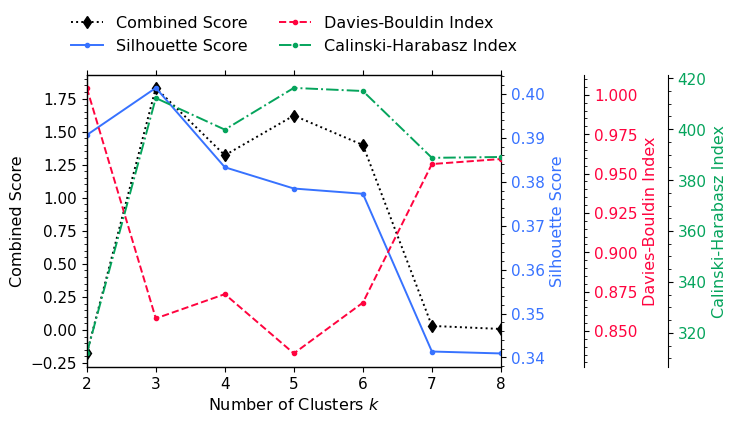

Optimal number of clusters based on Silhouette score: 3
Maximum Silhouette score: 0.401
Optimal number of clusters based on Davies-Bouldin index: 5
Minimum Davies-Bouldin index: 0.836
Optimal number of clusters based on Calinski-Harabasz index: 5
Maximum Calinski-Harabasz index: 416.230
Optimal number of clusters based on combined score: 3
Maximum combined score: 1.830


In [19]:
# === Find optimal number of clusters (Gaussian Mixture Model) =====================================

# Calculate silhouette scores, Davies-Bouldin scores, and Calinski-Harabasz scores for different values of k
silhouette_scores = []
db_scores = []
ch_scores = []
k_list = list(range(2, 9))
for k in k_list:
    # Apply K-means clustering with k clusters
    gmm = GaussianMixture(n_components=k, random_state=seed_dob)
    cluster_labels = gmm.fit_predict(X_pca)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    # Calculate Davies-Bouldin score
    db_index = davies_bouldin_score(X_pca, cluster_labels)
    db_scores.append(db_index)
    # Calculate Calinski-Harabasz score
    ch_index = calinski_harabasz_score(X_pca, cluster_labels)
    ch_scores.append(ch_index)

# Calculate combined scores for different values of k
combined_scores = calculate_combined_scores(silhouette_scores, ch_scores, db_scores)

# Plot scores for different values of k
fig, ax1 = plt.subplots(figsize=(7.5, 4.5))

# Plot combined score
ax1.plot(k_list, combined_scores, marker='d', linestyle=':', color='black', label='Combined Score')
ax1.set_xlabel('Number of Clusters $k$')
ax1.set_ylabel('Combined Score', color='black')
ax1.tick_params('y', colors='black')

# Plot silhouette score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color=sd2022_blue)
ax2.plot(k_list, silhouette_scores, marker='.', linestyle='-', color=sd2022_blue, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=sd2022_blue)

# Plot Davies-Bouldin Index
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  
ax3.set_ylabel('Davies-Bouldin Index', color=sd2022_red)
ax3.plot(k_list, db_scores, marker='.', linestyle='--', color=sd2022_red, label='Davies-Bouldin Index')
ax3.tick_params(axis='y', labelcolor=sd2022_red)

# Plot Calinski-Harabasz Index
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  
ax4.set_ylabel('Calinski-Harabasz Index', color=sd2022_green)
ax4.plot(k_list, ch_scores, marker='.', linestyle='-.', color=sd2022_green, label='Calinski-Harabasz Index')
ax4.tick_params(axis='y', labelcolor=sd2022_green)

# Combine legends from all axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
lines = lines1 + lines2 + lines3 + lines4
labels = labels1 + labels2 + labels3 + labels4
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
plt.xticks(k_list)
ax = plt.gca()
ax.xaxis.set_minor_locator(plt.NullLocator())
plt.show()

# Find the optimal number of clusters based on different metrics
max_silhouette_score = max(silhouette_scores)
optimal_k_silhouette = k_list[silhouette_scores.index(max_silhouette_score)]
print(f'Optimal number of clusters based on Silhouette score: {optimal_k_silhouette}')
print(f'Maximum Silhouette score: {max_silhouette_score:.3f}')

min_db_score = min(db_scores)
optimal_k_db = k_list[db_scores.index(min_db_score)]
print(f'Optimal number of clusters based on Davies-Bouldin index: {optimal_k_db}')
print(f'Minimum Davies-Bouldin index: {min_db_score:.3f}')

max_ch_score = max(ch_scores)
optimal_k_ch = k_list[ch_scores.index(max_ch_score)]
print(f'Optimal number of clusters based on Calinski-Harabasz index: {optimal_k_ch}')
print(f'Maximum Calinski-Harabasz index: {max_ch_score:.3f}')

max_combined_score = max(combined_scores)
optimal_k_combined = k_list[combined_scores.index(max_combined_score)]
print(f'Optimal number of clusters based on combined score: {optimal_k_combined}')
print(f'Maximum combined score: {max_combined_score:.3f}')

In [20]:
# === Centroid Matching Function ===================================================================

def centroid_matcher(centroids1, centroids2):
    """Matches centroids from two sets of clusters based on the minimum distance
    between them in a greedy one-to-one matching.

    The function takes two sets of centroids and returns the indices of the
    matched centroids. The function uses the scipy.spatial.distance_matrix
    function to calculate the distance matrix between the centroids and then
    iterates through the rows of the distance matrix to find the closest
    centroid in the second set of clusters. The function then appends the
    indices of the matched centroids to two lists and sets the distance between
    the matched centroids to infinity to avoid rematching.

    Args:
        centroids1 (numpy.ndarray): Centroids from the first set of clusters.
        centroids2 (numpy.ndarray): Centroids from the second set of clusters.

    Returns:
        match_ix1 (list): List of indices of the matched centroids from the 
        first set of clusters.
        match_ix2 (list): List of indices of the matched centroids from the 
        second set of clusters.

    References:
        Marek Slipski, Armin Kleinboehl, Steven Dillmann, David M Kass, Jason 
        Reimuller, Mark Wronkiewicz, and Gary Doran. The Cloudspotting on Mars 
        Citizen Science Project: Seasonal and spatial cloud distributions 
        observed by the mars climate sounder. Icarus, page 115777, 2023.
    """
    # Initialise lists to store the matched indices
    match_ix1 = []
    match_ix2 = []
    # Calculate the distance matrix between the centroids
    distances = cosine_distances(centroids1, centroids2)
    for index1 in range(len(centroids1)):
        # Find the index of the closest centroid in the second set of clusters
        index2 = np.argmin(distances[index1, :])
        # Append the indices to the lists of matched indices
        match_ix1.append(index1)
        match_ix2.append(index2)
        # Set the matched centroid distances to infinity to avoid rematching
        distances[index1, :] = np.inf
        distances[:, index2] = np.inf
    return match_ix1, match_ix2

In [21]:
# === Apply K-means clustering =====================================================================

# Apply K-means clustering with optimal number of clusters
k_optimal = 3
kmeans = KMeans(n_clusters=k_optimal, random_state=seed_year)

# Fit the model to the data
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Retrieve cluster centroids
centroids_kmeans = kmeans.cluster_centers_

# === Apply Gaussian Mixture Model =================================================================
k_optimal = 3
gmm = GaussianMixture(n_components=k_optimal, random_state=seed_year)
# Fit the model to the data
clusters_gmm = gmm.fit_predict(X_scaled)

# Retrieve cluster centroids manually
centroids_gmm = []
for c in np.unique(clusters_gmm):
    cluster_points = X_scaled[clusters_gmm == c]
    centroid = np.mean(cluster_points, axis=0)
    centroids_gmm.append(centroid)

# === Contingency Table ============================================================================

# Realign cluster labels using centroid matching indices
match_ix1, match_ix2 = centroid_matcher(centroids_kmeans, centroids_gmm)
aligned_labels_kmeans = np.array([match_ix2[label] for label in clusters_kmeans])
aligned_labels_gmm = np.array([match_ix1[label] for label in clusters_gmm])
df_scaled['cluster_kmeans'] = aligned_labels_kmeans
df_scaled['cluster_gmm'] = aligned_labels_gmm
df_pca['cluster_kmeans'] = aligned_labels_kmeans
df_pca['cluster_gmm'] = aligned_labels_gmm

# Create a contingency table for k-means clustering
contingency = pd.crosstab(df_scaled['cluster_kmeans'], df_scaled['cluster_gmm'])
print('Contingency table:')
print(contingency)

# Print adjusted rand index as a measure of cluster agreement
ari = adjusted_rand_score(df_scaled['cluster_kmeans'], df_scaled['cluster_gmm'])
print(f'Adjusted Rand Index: {ari:.3f}')


Contingency table:
cluster_gmm       0    1    2
cluster_kmeans               
0               117    1    3
1                 1  144   21
2                77    0  136
Adjusted Rand Index: 0.523


(b) For each of the clusterings you have obtained in (a), train a classifier to predict cluster membership and use this to identify the most discriminative features. In each case, apply the same clustering technique using only this subset of features. In your report, compare the partitions using the subset of features against the ones obtained using the entire dataset.

In [22]:
def find_knee_point(cumulative, knee_criteria):
    # Calculate the relative change between consecutive values
    relative_change = np.diff(cumulative) / cumulative[:-1]
    # Find the knee point based on the relative change and knee criteria
    knee_point = np.argmax(relative_change <= knee_criteria) + 1
    return knee_point 

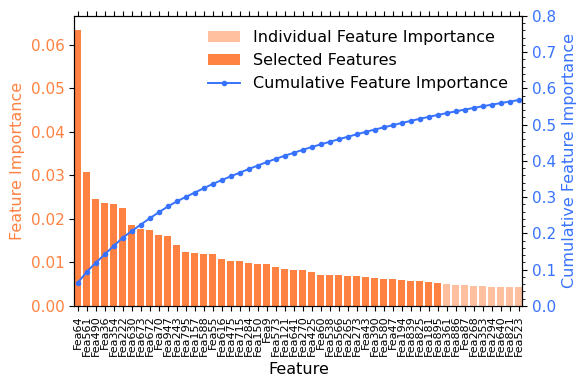

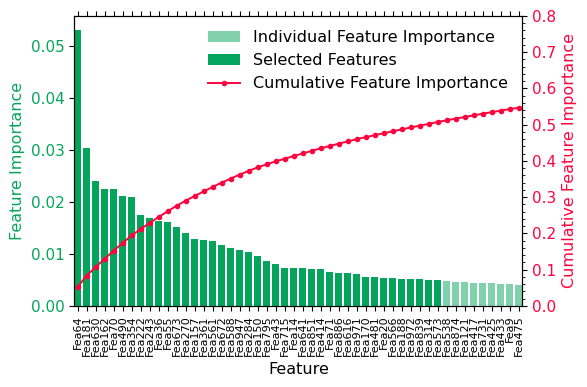

In [23]:
# === Train a Random Forest Classifier =============================================================

# Split into features X and labels y
X = df_scaled.drop(['type','cluster_kmeans','cluster_gmm'], axis=1)
y_kmeans = np.array(df_scaled['cluster_kmeans'])
y_gmm = np.array(df_scaled['cluster_gmm'])

# Train a default Random Forest Classifier on the k-means labels
rf_kmeans = RandomForestClassifier(random_state=seed_fave_song)
rf_kmeans.fit(X, y_kmeans)

# Train a default Random Forest Classifier on the GMM labels
rf_gmm = RandomForestClassifier(random_state=seed_fave_song)
rf_gmm.fit(X, y_gmm)

# Get feature importances
feature_importances_kmeans = rf_kmeans.feature_importances_
feature_importances_gmm = rf_gmm.feature_importances_

# Sort feature importances in descending order for k-means
indices_kmeans = np.argsort(feature_importances_kmeans)[::-1]
sorted_feature_importance_kmeans = feature_importances_kmeans[indices_kmeans][:50]
sorted_feature_names_kmeans = X.columns[indices_kmeans]
cumulative_importance_kmeans = np.cumsum(sorted_feature_importance_kmeans)

# Sort feature importances in descending order for GMM
indices_gmm = np.argsort(feature_importances_gmm)[::-1]
sorted_feature_importance_gmm = feature_importances_gmm[indices_gmm][:50]
sorted_feature_names_gmm = X.columns[indices_gmm]
cumulative_importance_gmm = np.cumsum(sorted_feature_importance_gmm)

# Select the top features based on the knee point in the cumulative error curve
n_features_to_select_kmeans = find_knee_point(cumulative_importance_kmeans,knee_criteria=0.01)
n_features_to_select_gmm = find_knee_point(cumulative_importance_gmm,knee_criteria=0.01)
n_features_to_select = max(n_features_to_select_kmeans, n_features_to_select_gmm)
top_feature_importance_kmeans = sorted_feature_importance_kmeans[:n_features_to_select]
top_feature_names_kmeans = sorted_feature_names_kmeans[:n_features_to_select]
top_feature_importance_gmm = sorted_feature_importance_gmm[:n_features_to_select]
top_feature_names_gmm = sorted_feature_names_gmm[:n_features_to_select]

# Plot the feature importances for k-means
fig, ax1 = plt.subplots()
ax1.bar(range(len(sorted_feature_importance_kmeans)), sorted_feature_importance_kmeans, color=sd2022_orange, alpha = 0.5, label='Individual Feature Importance')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Feature Importance', color=sd2022_orange)
ax1.tick_params(axis='y', labelcolor=sd2022_orange)
ax1.set_xticks(np.arange(len(sorted_feature_names_kmeans)))
ax1.set_xticklabels(sorted_feature_names_kmeans, rotation=90, fontsize=8)
ax1.minorticks_off()

# Plot the cumulative importances
ax2 = ax1.twinx()
ax2.plot(range(len(sorted_feature_importance_kmeans)), cumulative_importance_kmeans, color=sd2022_blue, marker='.', label='Cumulative Feature Importance')
ax2.set_ylabel('Cumulative Feature Importance', color=sd2022_blue)
ax2.tick_params(axis='y', labelcolor=sd2022_blue)
ax2.set_ylim(bottom=0.0, top=0.8)

# Plot the chosen number of components
ax1.bar(range(n_features_to_select), top_feature_importance_kmeans, color= sd2022_orange, label='Selected Features')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

plt.show()

# Plot the feature importances for GMM
fig, ax1 = plt.subplots()
ax1.bar(range(len(sorted_feature_importance_gmm)), sorted_feature_importance_gmm, color=sd2022_green, alpha = 0.5, label='Individual Feature Importance')
ax1.set_xlabel('Feature')
ax1.set_ylabel('Feature Importance', color=sd2022_green)
ax1.tick_params(axis='y', labelcolor=sd2022_green)

ax1.set_xticks(np.arange(len(sorted_feature_names_gmm)))
ax1.set_xticklabels(sorted_feature_names_gmm, rotation=90, fontsize=8)
ax1.minorticks_off()

# Plot the cumulative importances
ax2 = ax1.twinx()
ax2.plot(range(len(sorted_feature_importance_gmm)), cumulative_importance_gmm, color=sd2022_red, marker='.', label='Cumulative Feature Importance')
ax2.set_ylabel('Cumulative Feature Importance', color=sd2022_red)
ax2.tick_params(axis='y', labelcolor=sd2022_red)
ax2.set_ylim(bottom=0.0, top=0.8)

# Plot the chosen number of components
ax1.bar(range(n_features_to_select), top_feature_importance_gmm, color= sd2022_green, label='Selected Features')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')

plt.show()


In [24]:
# === Apply k-means clustering with reduced features ===============================================

# Copy the dataframe
df_scaled_imp = df_scaled.copy()

# Get most important features
X_kmeans = df_scaled[top_feature_names_kmeans]
X_gmm = df_scaled[top_feature_names_gmm]

# Dimensionality reduction using PCA
pca = PCA(n_components=2)
X_pca_kmeans = pca.fit_transform(X_kmeans)
X_pca_gmm = pca.fit_transform(X_gmm)
df_pca_kmeans = pd.DataFrame(X_pca_kmeans, columns=['PC_1','PC_2'])
df_pca_gmm = pd.DataFrame(X_pca_gmm, columns=['PC_1','PC_2'])
df_pca_kmeans['type'] = y
df_pca_gmm['type'] = y

# Apply K-means clustering with optimal number of clusters
k_optimal = 3
kmeans_imp = KMeans(n_clusters=k_optimal, random_state=seed_year)

# Fit the model to the data
clusters_kmeans_imp = kmeans_imp.fit_predict(X_kmeans)

# Retrieve cluster centroids
centroids_kmeans_imp = kmeans_imp.cluster_centers_

# === Apply Gaussian Mixture Model =================================================================
k_optimal = 3
gmm_imp = GaussianMixture(n_components=k_optimal, random_state=seed_year)

# Fit the model to the data
clusters_gmm_imp = gmm.fit_predict(X_gmm)

# Retrieve cluster centroids manually
centroids_gmm_imp = []
for c in np.unique(clusters_gmm_imp):
    cluster_points = X_gmm[clusters_gmm_imp == c]
    centroid = np.mean(cluster_points, axis=0)
    centroids_gmm_imp.append(centroid)

# === Contingency Table ============================================================================

# Realign cluster labels using centroid matching indices
match_ix1, match_ix2 = centroid_matcher(centroids_kmeans_imp, centroids_gmm_imp)
aligned_labels_kmeans_imp = np.array([match_ix2[label] for label in clusters_kmeans_imp])
aligned_labels_gmm_imp = np.array([match_ix1[label] for label in clusters_gmm_imp])
df_scaled_imp['cluster_kmeans_imp'] = aligned_labels_kmeans_imp
df_scaled_imp['cluster_gmm_imp'] = aligned_labels_gmm_imp
df_pca['cluster_kmeans_imp'] = aligned_labels_kmeans_imp
df_pca['cluster_gmm_imp'] = aligned_labels_gmm_imp
df_pca_kmeans['cluster_kmeans_imp'] = aligned_labels_kmeans_imp
df_pca_gmm['cluster_gmm_imp'] = aligned_labels_gmm_imp

# Create a contingency table for k-means clustering
contingency = pd.crosstab(df_scaled_imp['cluster_kmeans_imp'], df_scaled_imp['cluster_gmm_imp'])
print('Contingency table:')
print(contingency)

# Print adjusted rand index as a measure of cluster agreement
ari_imp = adjusted_rand_score(df_scaled_imp['cluster_kmeans_imp'], df_scaled_imp['cluster_gmm_imp'])
print(f'Adjusted Rand Index: {ari_imp:.3f}')

Contingency table:
cluster_gmm_imp       0    1    2
cluster_kmeans_imp               
0                   117    2   40
1                     3  166    1
2                    32    6  133
Adjusted Rand Index: 0.604




=== K-MEANS CLUSTERING ==================================================================

Contingency table:
cluster_kmeans_imp    0    1    2
cluster_kmeans                   
0                   119    1    1
1                     3  163    0
2                    37    6  170
Adjusted Rand Index: 0.742


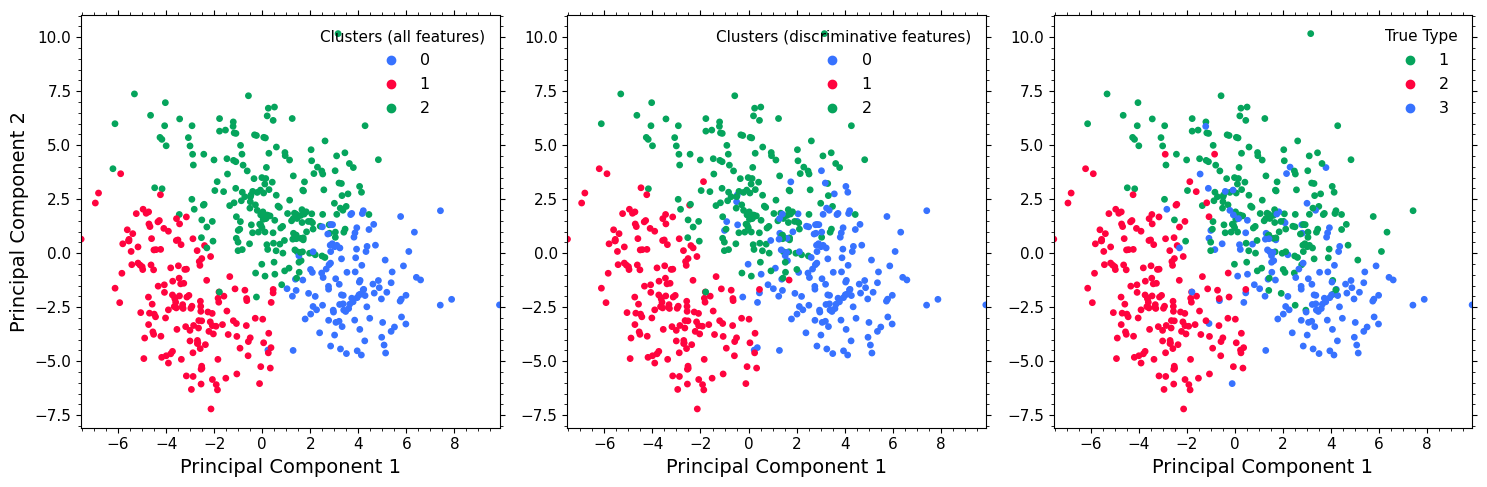



=== GAUSSIAN MIXTURE MODEL CLUSTERING ===================================================

Contingency table:
cluster_gmm_imp    0    1    2
cluster_gmm                   
0                144    4   47
1                  4  141    0
2                  4   29  127
Adjusted Rand Index: 0.563


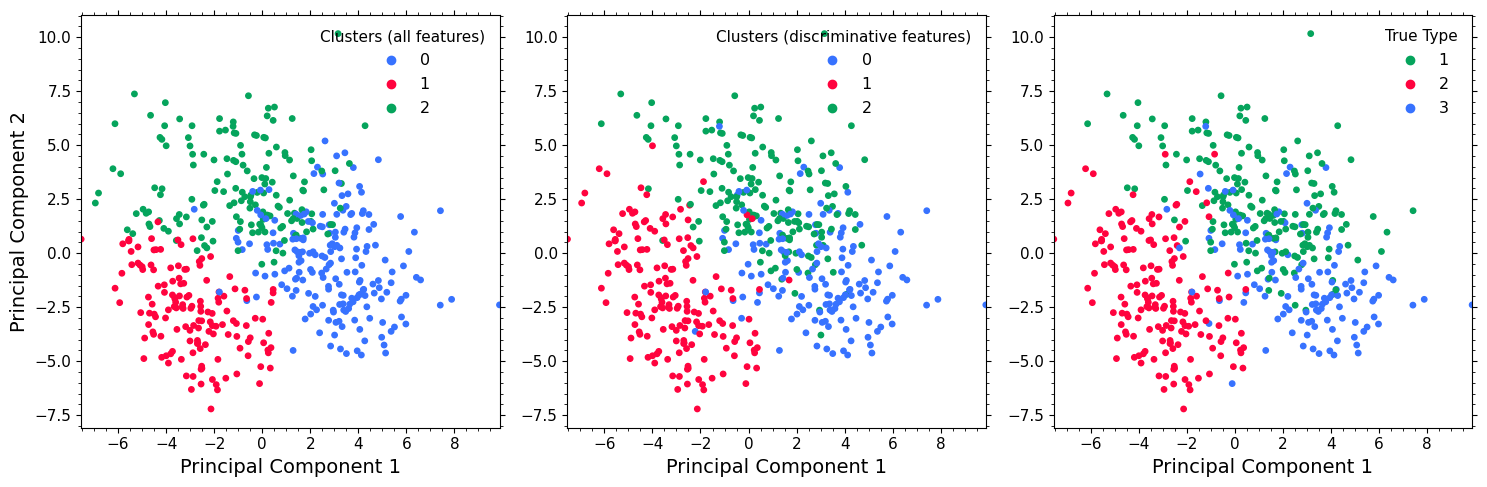

Silhouette Score for k-means (all features): 0.008
Silhouette Score for k-means (discriminative features): 0.017
Silhouette Score for GMM (all features): 0.021
Silhouette Score for GMM (discriminative features): 0.021
Silhouette Score for true labels: 0.020


In [25]:
# === Compare clusters on all vs discriminative features ===========================================

# === k-means Clustering ===========================================================================

print("\n\n=== K-MEANS CLUSTERING ==================================================================\n")
contingency_kmeans = pd.crosstab(df_scaled_imp['cluster_kmeans'], df_scaled_imp['cluster_kmeans_imp'])
print('Contingency table:')
print(contingency_kmeans)
ari_kmeans = adjusted_rand_score(df_scaled_imp['cluster_kmeans'], df_scaled_imp['cluster_kmeans_imp'])
print(f'Adjusted Rand Index: {ari_kmeans:.3f}')

# Plot clusters from all features, clusters from discriminative features, and true labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot clusters from all features
scatter1 = axes[0].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['cluster_kmeans'], cmap=colors_sd2022, s=15)
axes[0].set_xlabel('Principal Component 1', fontsize=14)
axes[0].set_ylabel('Principal Component 2', fontsize=14)
legend1 = axes[0].legend(*scatter1.legend_elements(), title='Clusters (all features)', loc='upper right')
# Plot clusters from discriminative features
scatter2 = axes[1].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['cluster_kmeans_imp'], cmap=colors_sd2022, s=15)
axes[1].set_xlabel('Principal Component 1', fontsize=14)
legend2 = axes[1].legend(*scatter2.legend_elements(), title='Clusters (discriminative features)', loc='upper right')
# Plot true labels
scatter3 = axes[2].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['type'], cmap=colors_sd2022_2, s=15)
axes[2].set_xlabel('Principal Component 1', fontsize=14)
legend3 = axes[2].legend(*scatter3.legend_elements(), title='True Type', loc='upper right')
plt.tight_layout()
plt.show()

# === Gaussian Mixture Model =======================================================================
print("\n\n=== GAUSSIAN MIXTURE MODEL CLUSTERING ===================================================\n")
contingency_gmm = pd.crosstab(df_scaled_imp['cluster_gmm'], df_scaled_imp['cluster_gmm_imp'])
print('Contingency table:')
print(contingency_gmm)
ari_gmm = adjusted_rand_score(df_scaled_imp['cluster_gmm'], df_scaled_imp['cluster_gmm_imp'])
print(f'Adjusted Rand Index: {ari_gmm:.3f}')

# Plot clusters from all features, clusters from discriminative features, and true labels

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot clusters from all features
scatter1 = axes[0].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['cluster_gmm'], cmap=colors_sd2022, s=15)
axes[0].set_xlabel('Principal Component 1', fontsize=14)
axes[0].set_ylabel('Principal Component 2', fontsize=14)
legend1 = axes[0].legend(*scatter1.legend_elements(), title='Clusters (all features)', loc='upper right')
# Plot clusters from discriminative features
scatter2 = axes[1].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['cluster_gmm_imp'], cmap=colors_sd2022, s=15)
axes[1].set_xlabel('Principal Component 1', fontsize=14)
legend2 = axes[1].legend(*scatter2.legend_elements(), title='Clusters (discriminative features)', loc='upper right')
# Plot true labels
scatter3 = axes[2].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['type'], cmap=colors_sd2022_2, s=15)
axes[2].set_xlabel('Principal Component 1', fontsize=14)
legend3 = axes[2].legend(*scatter3.legend_elements(), title='True Type', loc='upper right')
plt.tight_layout()
plt.show()

# === Silhouette Scores ============================================================================

# Silhouette scores for k-means clustering
silhouette_kmeans_all = silhouette_score(df_scaled, df_scaled['cluster_kmeans'])
silhouette_kmeans_discriminative = silhouette_score(df_scaled_imp, df_scaled_imp['cluster_kmeans_imp'])

# Silhouette scores for GMM clustering
silhouette_gmm_all = silhouette_score(df_scaled, df_scaled['cluster_gmm'])
silhouette_gmm_discriminative = silhouette_score(df_scaled_imp, df_scaled_imp['cluster_gmm_imp'])

# Silhouette score for true labels
silhouette_true = silhouette_score(df_scaled, df_scaled['type'])

# Print the silhouette scores
print(f"Silhouette Score for k-means (all features): {silhouette_kmeans_all:.3f}")
print(f"Silhouette Score for k-means (discriminative features): {silhouette_kmeans_discriminative:.3f}")
print(f"Silhouette Score for GMM (all features): {silhouette_gmm_all:.3f}")
print(f"Silhouette Score for GMM (discriminative features): {silhouette_gmm_discriminative:.3f}")
print(f"Silhouette Score for true labels: {silhouette_true:.3f}")




(c) Visualise the clusters in a lower-dimensional space and colour each point according (i) the cluster membership, (ii) the value of the most discriminative feature, (iii) the value of the next most discriminative feature.



=== K-MEANS CLUSTERING ==================================================================



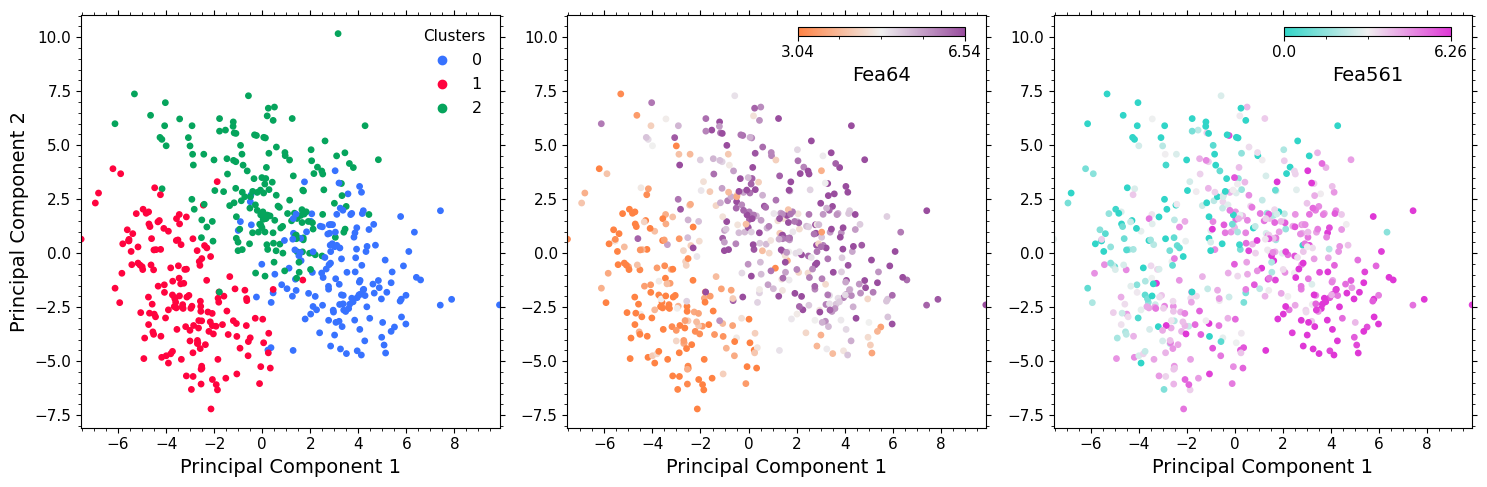



=== GAUSSIAN MIXTURE MODEL CLUSTERING ===================================================



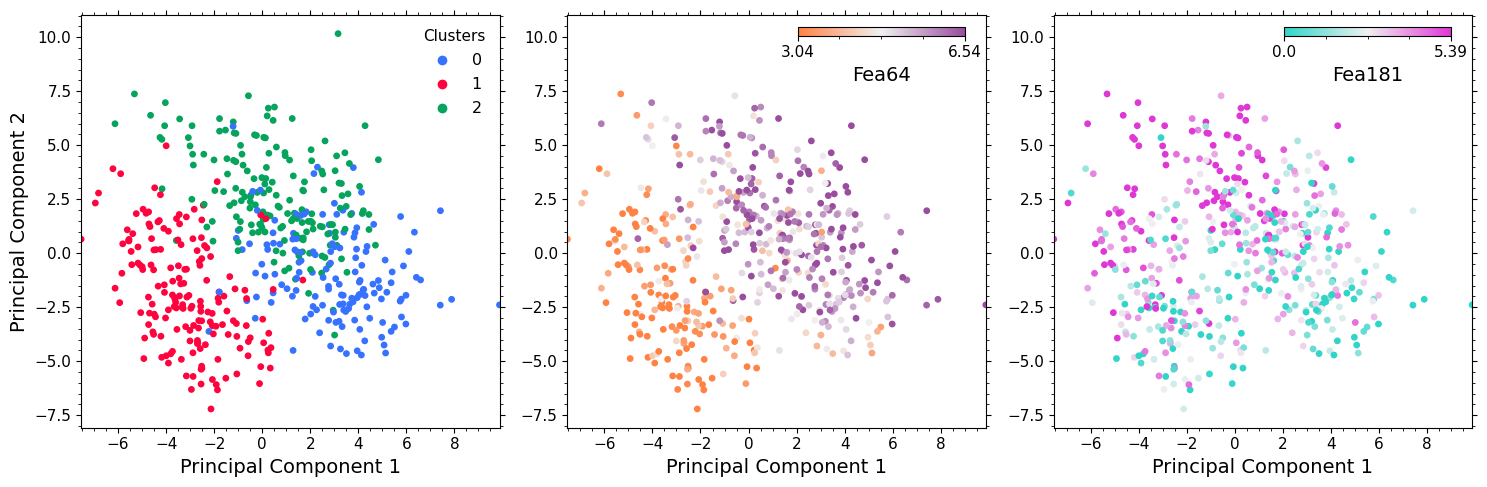

In [26]:
# === Visualise k-means clusters ===================================================================

# Get most discriminative feature name
first_top_feature_name_kmeans = top_feature_names_kmeans[0]
first_top_feature_name_gmm = top_feature_names_gmm[0]

# Get second most discriminative feature name
second_top_feature_name_kmeans = top_feature_names_kmeans[1]
second_top_feature_name_gmm = top_feature_names_gmm[1]

# === k-means Clustering ===========================================================================
print("\n\n=== K-MEANS CLUSTERING ==================================================================\n")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the clusters coloured by (i) cluster membership
scatter1 = axes[0].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['cluster_kmeans_imp'], cmap=colors_sd2022, s=15)
axes[0].set_xlabel('Principal Component 1', fontsize=14)
axes[0].set_ylabel('Principal Component 2', fontsize=14)
legend1 = axes[0].legend(*scatter1.legend_elements(), title='Clusters', loc='upper right')
# Plot the clusters coloured by (ii) value of most discriminative feature
scatter2 = axes[1].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_scaled_imp[first_top_feature_name_kmeans], cmap = cmap_owp, s=15,  norm=Normalize(vmin=-1, vmax=1))
axes[1].set_xlabel('Principal Component 1', fontsize=14)
ax_bar = axes[1].inset_axes([0.55, 0.95, 0.4, 0.02]) 
cbar = plt.colorbar(scatter2, cax=ax_bar, orientation='horizontal')
cbar.set_label(first_top_feature_name_kmeans, fontsize=14)
cbar.set_ticks([cbar.vmin, cbar.vmax]) 
cbar.set_ticklabels([round(df[first_top_feature_name_kmeans].min(),2), round(df[first_top_feature_name_kmeans].max(),2)])
# Plot the clusters coloured by (iii) value of second most discriminative feature
scatter2 = axes[2].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_scaled_imp[second_top_feature_name_kmeans], cmap = cmap_twp, s=15, norm=Normalize(vmin=-1, vmax=1))
axes[2].set_xlabel('Principal Component 1', fontsize=14)
ax_bar = axes[2].inset_axes([0.55, 0.95, 0.4, 0.02])
cbar = plt.colorbar(scatter2, cax=ax_bar, orientation='horizontal')
cbar.set_label(second_top_feature_name_kmeans, fontsize=14)
cbar.set_ticks([cbar.vmin, cbar.vmax])
cbar.set_ticklabels([round(df[second_top_feature_name_kmeans].min(),2), round(df[second_top_feature_name_kmeans].max(),2)])
plt.tight_layout()
plt.show()

# === Gaussian Mixture Model =======================================================================
print("\n\n=== GAUSSIAN MIXTURE MODEL CLUSTERING ===================================================\n")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Plot the clusters coloured by (i) cluster membership
scatter1 = axes[0].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_pca['cluster_gmm_imp'], cmap=colors_sd2022, s=15)
axes[0].set_xlabel('Principal Component 1', fontsize=14)
axes[0].set_ylabel('Principal Component 2', fontsize=14)
legend1 = axes[0].legend(*scatter1.legend_elements(), title='Clusters', loc='upper right')
# Plot the clusters coloured by (ii) value of most discriminative feature
scatter2 = axes[1].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_scaled_imp[first_top_feature_name_gmm], cmap = cmap_owp, s=15, norm=Normalize(vmin=-1, vmax=1))
axes[1].set_xlabel('Principal Component 1', fontsize=14)
ax_bar = axes[1].inset_axes([0.55, 0.95, 0.4, 0.02])
cbar = plt.colorbar(scatter2, cax=ax_bar, orientation='horizontal')
cbar.set_label(first_top_feature_name_gmm, fontsize=14)
cbar.set_ticks([cbar.vmin, cbar.vmax])
cbar.set_ticklabels([round(df[first_top_feature_name_gmm].min(),2), round(df[first_top_feature_name_gmm].max(),2)])
# Plot the clusters coloured by (iii) value of second most discriminative feature
scatter2 = axes[2].scatter(df_pca['PC_1'], df_pca['PC_2'], c=df_scaled_imp[second_top_feature_name_gmm], cmap = cmap_twp, s=15, norm=Normalize(vmin=-1, vmax=1))
axes[2].set_xlabel('Principal Component 1', fontsize=14)
ax_bar = axes[2].inset_axes([0.55, 0.95, 0.4, 0.02])
cbar = plt.colorbar(scatter2, cax=ax_bar, orientation='horizontal')
cbar.set_label(second_top_feature_name_gmm, fontsize=14)
cbar.set_ticks([cbar.vmin, cbar.vmax])
cbar.set_ticklabels([round(df[second_top_feature_name_gmm].min(),2), round(df[second_top_feature_name_gmm].max(),2)])
plt.tight_layout()
plt.show()